# Bayesian Data Analysis

## PPCA with missing data in STAN
Illustration of PPCA using Stan for parameter and missing data estimation

In [7]:
import numpy as np
import pystan
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import linalg
import copy
# edit default plot settings (colours from colorbrewer2.org)
plt.rc('figure', figsize=(8,6))
plt.rc('font', size=14)
plt.rc('lines', color='#377eb8', linewidth=2)
plt.rc('axes', color_cycle=('#377eb8','#e41a1c','#4daf4a',
                            '#984ea3','#ff7f00','#ffff33'))

/Users/nbip/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Introducing missing data
Now we introduce missing data. Each entry in the data matrix is set to missing with probability $m$. This corresponds to missing completely at random.

This notebook aims to
* Get a posterior distribution for PPCA parameters in the presence of missing data
* Get estimates for the missing data


In [8]:
class createData:
    'documentation'
    
    def __init__(self,d,dl,n,mu,sigma2):
        # sample latent variable Z
        self.Z = np.random.multivariate_normal(np.zeros(dl),np.identity(dl),n).T  # dl x n    

        # create additive noise
        noise = np.random.multivariate_normal(np.zeros(d),sigma2*np.identity(d),n).T  # d x n
        
        # create orthogonal signal directions
        self.W = linalg.orth(np.random.random((d,dl)))  # d x dl

        # data-space data
        self.Y = np.dot(self.W,self.Z) + noise;
        
        
    def removeData(self,m):
        # copy of original data
        y_miss = copy.copy(self.Y)
        # indicator matrix, 1 for present, 0 for missing
        S = np.ones((d,n))        
        
        # matrix of uniformly distributed random numbers
        r = np.random.uniform(0,1,(d,n))
        
        # boolean of those lower than specified missing rate
        bol = r<m
        
        # set entries to nan as specified by bol
        y_miss[bol] = np.nan
        S[bol] = 0
        
        return dict(y_miss=y_miss,S=S)

In [9]:
d=2           # data-space dimensions
dl=1          # latent space dimensions
n=500
mu=np.zeros(d)
sigma2=0.05

datObj = createData(d,dl,n,mu,sigma2)
# extract quantities
Y = datObj.Y
W = datObj.W
Z = datObj.Z

In [10]:
# missing rate
m = 0.2
missDict = datObj.removeData(m)
y_miss = missDict['y_miss']
S = missDict['S']

## Data distribution and missing data
Red stars signify observations where one or more features have been set to missing. The plot to the right illustrate full observations as blue dots and partial observations are shown on the axis where a feature is observed

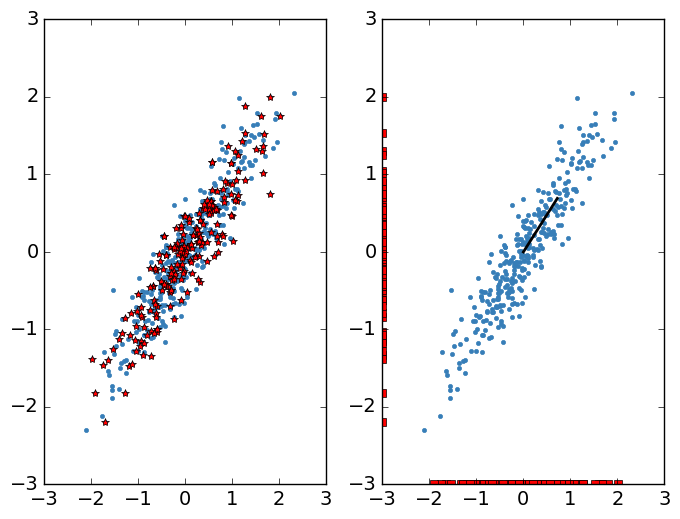

In [11]:
# full data
plt.subplot(1,2,1)
plt.plot(Y[0,:],Y[1,:],'.')
# data with one or more features missng
ind_miss = np.where(S==0)
ind_miss = np.asarray(ind_miss).T
plt.plot(Y[0,ind_miss[:,1]],Y[1,ind_miss[:,1]],'r*')
#plt.axis('equal')

axes = plt.gca()
ylim = axes.get_ylim()
xlim = axes.get_xlim()

plt.subplot(1,2,2)
sumS = np.sum(S,axis=0)
ind_full = np.where(sumS==d)
ind_full = np.asarray(ind_full).T
plt.plot(Y[0,ind_full],Y[1,ind_full],'.')
l = int(n-np.sum(S[0,:]))
ind_one = ind_miss[1:l,:]    # indices for missing 1st coordinate
ind_two = ind_miss[l:,:]     # indices for missing 2nd coordinate

# put observations with missing x-coordinate on the y-axis
plt.plot(xlim[0]*np.ones(len(ind_one)),y_miss[1,ind_one[:,1]],'rs')
# put observations with missing y-coordinate on the x-axis
plt.plot(y_miss[0,ind_two[:,1]],ylim[0]*np.ones(len(ind_two)),'rs')
# principal component
plt.plot([0,W[0]],[0,W[1]],'k')
axes=plt.gca()
axes.set_ylim(ylim)
axes.set_xlim(xlim);



### Vector of complete data and matrix of indices for present data

In [12]:
dat_complete = np.squeeze(y_miss[S==1])
Ncomp = len(dat_complete) # number of present observations
ind_pres = np.where(S==1)
ind_pres = np.asarray(ind_pres).T
ind_pres = [x+1 for x in ind_pres] # conform to Stan matrix notation
ind_pres = np.asarray(ind_pres)

### Matrix of indices for missing data

In [13]:
ind_miss = np.where(S==0)
ind_miss = np.asarray(ind_miss).T
Nmiss = len(ind_miss)
ind_miss = [x+1 for x in ind_miss] # conform to Stan matrix notation
ind_miss = np.asarray(ind_miss)

### Stan model for missing data in PPCA

In [14]:
# =============== PPCA model for missing data ===================
ppca_missing_code = """
data {
  int<lower=1> N;              // num datapoints
  int<lower=1> D;              // num dimension
  int<lower=1> K;              // num basis
  real<lower=0> ones;
 
  int<lower=0> Ncomp; // Number of non-missing values
  int<lower=0> Nmiss; // Number of missing values
 
  real dat_complete[Ncomp];   // Vector of non-missing values
  int ind_pres[Ncomp,2];      // Matrix (row, col) of non-missing value indices
  int ind_miss[Nmiss,2];      // Matrix (row, col) of missing value indices
}
transformed data {
  matrix[K,K] Sigma;
  vector<lower=0>[K] diag_elem;
  vector<lower=0>[K] zr_vec;
  for (k in 1:K) zr_vec[k] <- 0;
  for (k in 1:K) diag_elem[k] <- ones;
  Sigma <- diag_matrix(diag_elem);
}
parameters {
  matrix[D,K] A;            // basis
  vector[K] x[N];           // coefficients
  real<lower=0> sigma;      // noise variance
 
  // Vector containing "stochastic" nodes (for filling in missing values)
  real ymiss[Nmiss]; 
}
transformed parameters{
 
    real y[D,N]; // The "data" with interpolated missing values
 
  // Fill y with non-missing values 
  for(n in 1:Ncomp) 
    y[ind_pres[n,1]][ind_pres[n,2]] <- dat_complete[n];
  
  // Fill the rest of y with missing value "parameters"
  for(n in 1:Nmiss)
    y[ind_miss[n,1]][ind_miss[n,2]] <- ymiss[n];
  
}
model {  
  
  for (i in 1:N)
      x[i] ~ multi_normal(zr_vec, Sigma);
      
  
  for (i in 1:N)
    for (d in 1:D)
      //y[d,i] ~ normal(dot_product(row(A, d), x[i]), sigma);
      increment_log_prob(normal_log(y[d,i], dot_product(row(A, d), x[i]), sigma));      
}
generated quantities {
    vector[N] log_lik;
    for (n in 1:N)
       for (d in 1:D)
        log_lik[n] <- normal_log(y[d,n], dot_product(row(A, d), x[n]), sigma);
}
"""
data = dict(N=n, D=d, K=dl, ones=1, 
            Ncomp=Ncomp, Nmiss=Nmiss, 
            dat_complete=dat_complete, 
            ind_pres=ind_pres, ind_miss = ind_miss)
fit = pystan.stan(model_code=ppca_missing_code, data=data)
print(fit)
samples = fit.extract(permuted=True)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_90d0aea0ce0a7e2abb257d75a72c494b NOW.


Inference for Stan model: anon_model_90d0aea0ce0a7e2abb257d75a72c494b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
A[0,0]         0.39    0.47   0.67  -0.81  -0.07   0.76   0.79   0.83      2   26.6
A[1,0]         0.39    0.48   0.67  -0.81  -0.07   0.76   0.79   0.83      2  26.07
x[0,0]         0.33    0.43   0.61  -0.93   0.02   0.58   0.74   1.02      2   3.32
x[1,0]        -0.61    0.77   1.08   -1.6  -1.32  -1.13   0.07   1.48      2   5.59
x[2,0]        -0.43    0.54   0.77  -1.22  -0.94  -0.77   0.09   1.09      2   4.18
x[3,0]         0.23    0.31   0.45  -0.73  -0.04   0.37   0.56   0.82      2   2.35
x[4,0]         0.29    0.38   0.54  -0.81   0.02   0.49   0.66   0.95      2    2.9
x[5,0]         -0.6    0.76   1.08   -1.7  -1.33  -1.09   0.06   1.56      2   4.17
x[6,0]        -0.09    0.12   0.24  -0.53  -0.25   -0.1

## Transformation matrix (principal components)
The column vectors of the transformation matrix $W$ spans the principal subspace, but does not necessarily give the "traditional" principal components. In order to get these, orthonormalize the solution

In [18]:
A = samples['A']
A = A[:,:,0]
W_est = np.mean(abs(A.T),1)[np.newaxis]   
# newaxis becuase the mean of A is just a 1D array and in Python this cannot be transposed
W_est = linalg.orth(W_est.T)

In [19]:
sig = np.sign(samples['A'])
np.unique(sig[:,0]*sig[:,1])

array([ 1.])

In [20]:
print('The estimated weights are W=[{:f}, {:f}]\n'.format(W_est[0,0],W_est[1,0]))
print('The true weights are W=[{:f}, {:f}]\n'.format(W[0,0],W[1,0]))

The estimated weights are W=[0.706221, 0.707992]

The true weights are W=[0.722429, 0.691445]



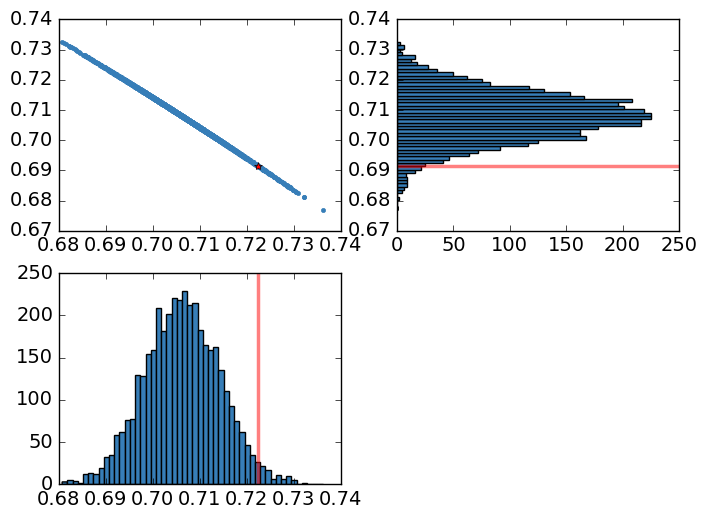

In [21]:
orth_A = np.zeros(A.shape) # initialize empty matrix to hold orthonormalized samples for A

for i in range(0,len(A)):
    orth_A[i,:] = linalg.orth(abs(A[i,:])[np.newaxis].T).T
    

fig = plt.figure()

ax1 = fig.add_subplot(221)
ax1.plot(orth_A[:,0],orth_A[:,1],'.')
ax1.plot(W[0],W[1],'r*')
axes = plt.gca()

ax2 = fig.add_subplot(222)
ax2.hist(orth_A[:,1],50,orientation='horizontal')
ax2.axhline(W[1], color='#ff0000', linewidth=2.5, alpha=0.5)

ax3 = fig.add_subplot(223)
ax3.hist(orth_A[:,0],50)
ax3.axvline(W[0], color='#ff0000', linewidth=2.5, alpha=0.5);

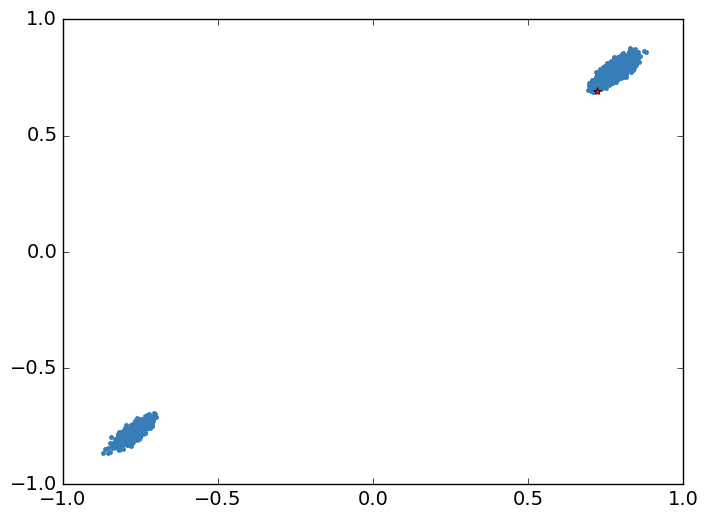

In [22]:
# original samples without orthonormalization
plt.plot(A[:,0],A[:,1],'.')
plt.plot(W[0],W[1],'r*');

## Noise variance

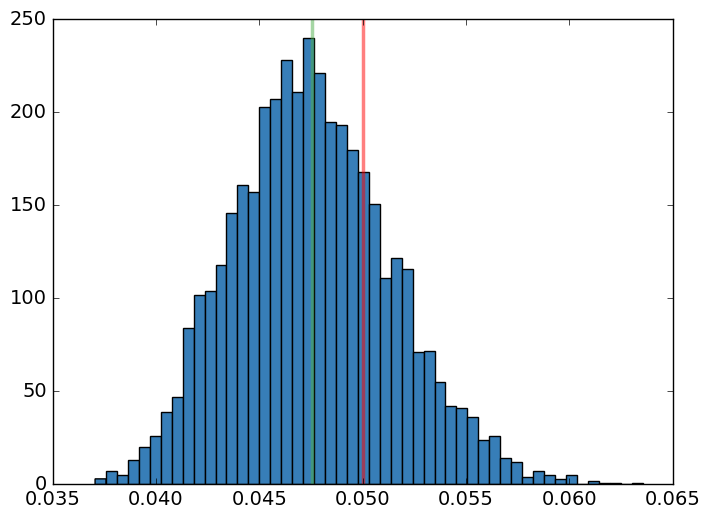

In [23]:
tmp = samples['sigma']
sigma = [x*x for x in tmp];
s2 = np.mean(sigma)
plt.hist(sigma,50)
plt.axvline(s2, color='#4daf4a', linewidth=2.5, alpha=0.5)
plt.axvline(sigma2, color='#ff0000', linewidth=2.5, alpha=0.5);

## Posterior on latent variable

In [24]:
x = samples['x']
x = x[:,:,0]

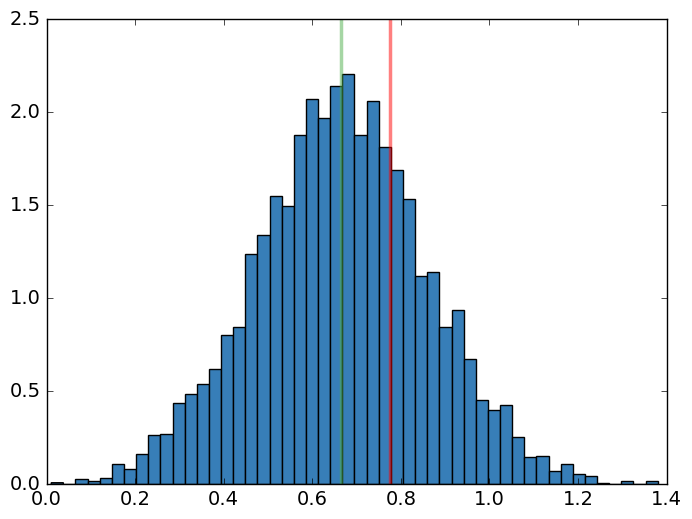

In [25]:
# create a new posterior for the latent variable, where the sign is corrected for
x_ = np.zeros(len(x[:,0]))
for i in range(0,len(x[:,0])):
    x_[i] = x[i,0]*sig[i,0]
    
plt.hist(x_,50,normed=True);
m1 = np.mean(x_)
plt.axvline(Z[0,0], color='#ff0000', linewidth=2.5, alpha=0.5)
plt.axvline(m1, color='#4daf4a', linewidth=2.5, alpha=0.5);

In [26]:
print('Original latent variable value:{:f}\n'.format(Z[0,0]))
print('Estimated latent varuable value:{:f}\n'.format(m1))

Original latent variable value:0.774629

Estimated latent varuable value:0.665555



## Posterior on latent variables: with missing features and without

In [27]:
# indices for an observation with missing features
ix = ind_miss[51,1]
x_miss = x[:,ix]
x_miss2 = np.zeros(len(x[:,0]))
for i in range(0,len(x[:,0])):
    x_miss2[i] = x_miss[i]*sig[i,0]

# indices for an observation without missing features
sumS = S[0,:] + S[1,:]
full_obs = np.where(sumS==2)

x_pres = x[:,full_obs[0][0]]
x_pres2 = np.zeros(len(x[:,0]))
for i in range(0,len(x[:,0])):
    x_pres2[i] = x_pres[i]*sig[i,0]

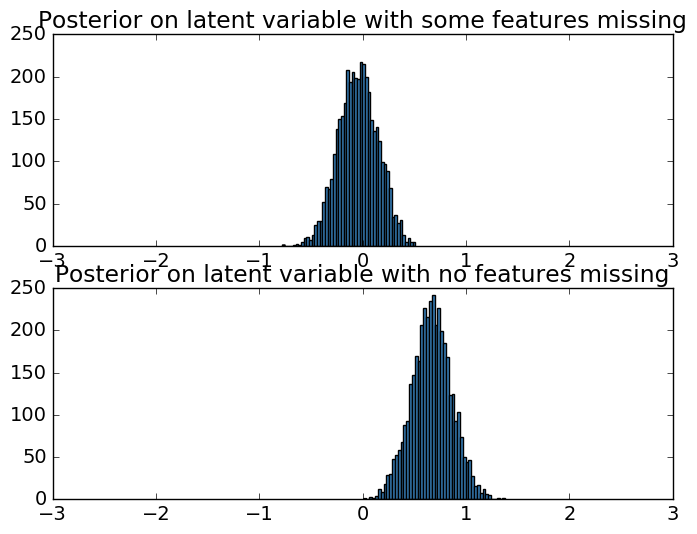

In [28]:
fig = plt.figure()

ax1 = fig.add_subplot(211)
ax1.hist(x_miss2,50)
axes = plt.gca()
axes.set_xlim([-3,3])
axes.title.set_text('Posterior on latent variable with some features missing')

ax2 = fig.add_subplot(212)
ax2.hist(x_pres2,50)
axes = plt.gca()
axes.set_xlim([-3,3])
axes.title.set_text('Posterior on latent variable with no features missing')

## Reconstructed data and emprical covariances

In [29]:
y_rec = samples['ymiss']
y_rec.shape
y_rec = np.mean(y_rec,axis=0)
bol = S<0.5
y_reconstructed = np.copy(y_miss)
y_reconstructed[bol] = y_rec


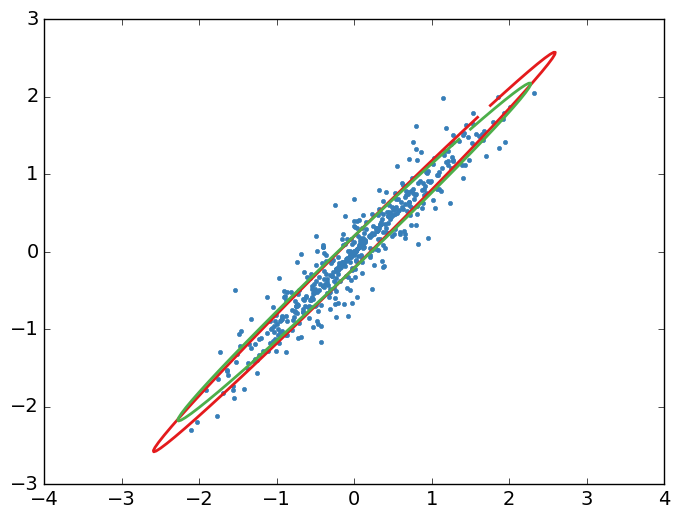

In [31]:
# full reconstructed data
plt.plot(y_reconstructed[0,:],y_reconstructed[1,:],'.')
# principal component
# plt.plot([0,W[0]],[0,W[1]],'k')
plt.axis('equal')

# covariance matrix for reconstructed data
cov_rec = np.cov(y_reconstructed)
cov_org = np.cov(Y)
cov_theo = np.dot(W,W.T) + sigma2*np.eye(d)
# contour lines
t = np.arange(0, 2*np.pi, 0.1)
p = np.asarray([np.sin(t), np.cos(t)])
contour1 = 3*np.dot(cov_rec,p)
contour2 = 3*np.dot(cov_org,p)
contour3 = 3*np.dot(cov_theo,p)
#plt.plot(contour1[0,:],contour1[1,:])
plt.plot(contour2[0,:],contour2[1,:])
plt.plot(contour3[0,:],contour3[1,:]);
#plt.legend(['reconstructed data','covariance countour - reconstructed data','covariance countour - original data','covariance countour - theoretical'])

# Missing data reconstruction


Original observation:               Observation after missing process:


[array([-0.33211559, -0.31513672]), array([        nan, -0.31513672])]

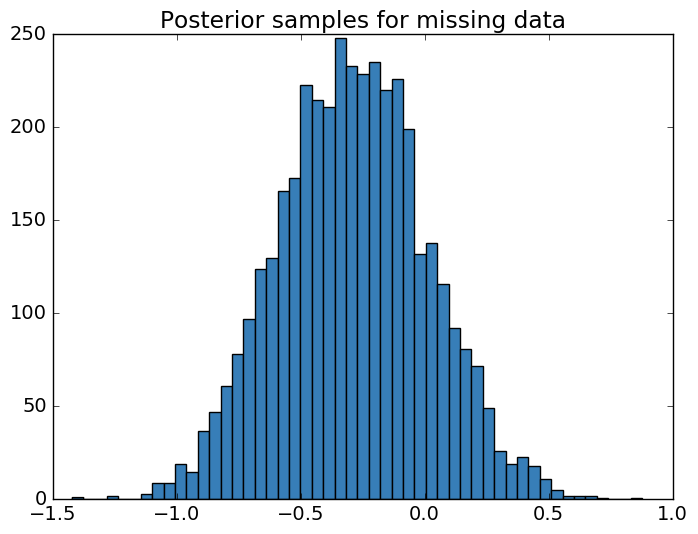

In [40]:
y_rec = samples['ymiss']

# samples for an observation with missing data
ix = 1
y1 = y_rec[:,ix]
plt.hist(y1,50);
plt.title('Posterior samples for missing data')
print('Original observation:               Observation after missing process:')
[Y[:,ind_miss[ix,1]-1], y_miss[:,ind_miss[ix,1]-1]]

## Show posterior samples for missing data togther with data distribution
Here you can select an observation with missing data and see how the posterior distribution looks. Change the ix number

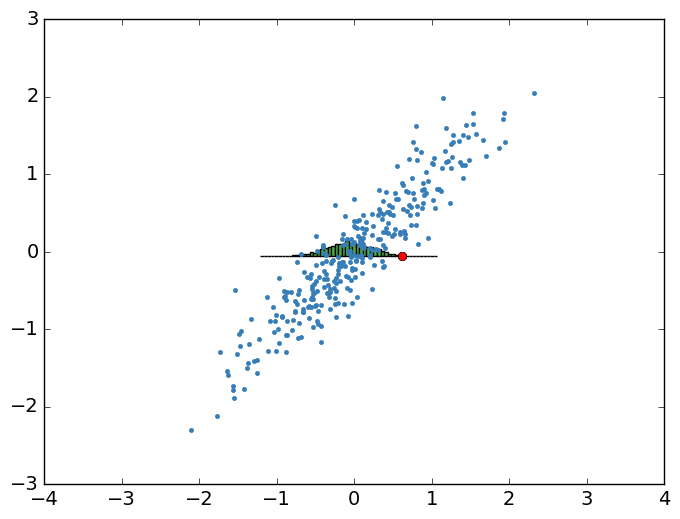

In [41]:
# choose an observation with one feature missing 
ix = 6

# check if both features are missing
check = np.isnan(y_miss[:,ind_miss[ix,1]-1])
if check[0] and check[1]:
    porg = [0,0]
else:
    porg = Y[:,ind_miss[ix,1]-1]
y1 = y_rec[:,ix]
hist_r = np.histogram(y1,50)


plt.plot(Y[0,ind_full],Y[1,ind_full],'.');
plt.bar(hist_r[1][:-1], hist_r[0]*0.2/hist_r[0].max(),
    width=hist_r[1][1]-hist_r[1][0], bottom=porg[1],color='#4daf4a')
plt.plot(porg[0],porg[1],'r8');
plt.axis('equal');

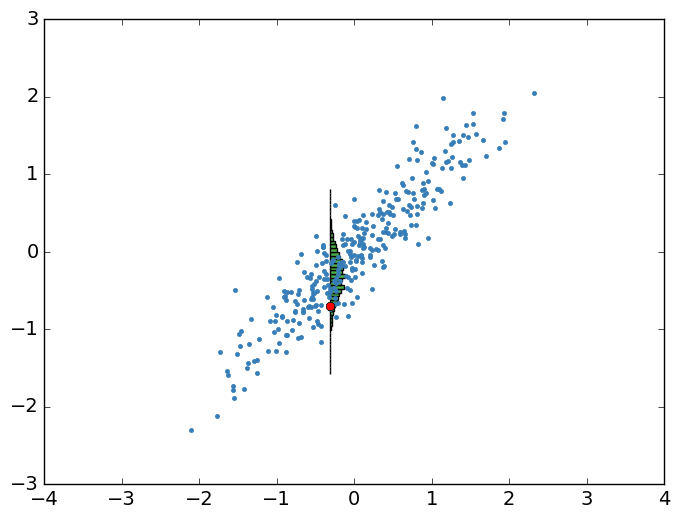

In [42]:
# similarly for the 2nd coordinate
# choose an observation with one feature missing 
# first move up to all the missing 2nd coordinates
add = np.where(ind_miss[:,0]==2)[0][0]
ix = add + 5

# check if both features are missing
check = np.isnan(y_miss[:,ind_miss[ix,1]-1])
if check[0] and check[1]:
    porg = [0,0]
else:
    porg = Y[:,ind_miss[ix,1]-1]
y1 = y_rec[:,ix]
hist_r = np.histogram(y1,50)


plt.plot(Y[0,ind_full],Y[1,ind_full],'.');
plt.barh(hist_r[1][:-1], hist_r[0]*0.2/hist_r[0].max(),
    height=hist_r[1][1]-hist_r[1][0], left=porg[0], color='#4daf4a')
plt.plot(porg[0],porg[1],'r8');
plt.axis('equal');